In [1]:
# Mount Google Drive to Google colab runtime

from google.colab import drive
drive.mount('/content/drive')# , force_remount = True)

Mounted at /content/drive


In [4]:
# Preparing the truncated folder

# Training folder curation
!rm -rf /content/drive/MyDrive/kaggle-one-shot-pokemon-truncated/pokemon-a
!mkdir -p /content/drive/MyDrive/kaggle-one-shot-pokemon-truncated/pokemon-a/
!cp /content/drive/MyDrive/kaggle-one-shot-pokemon/pokemon-a/1* /content/drive/MyDrive/kaggle-one-shot-pokemon-truncated/pokemon-a/
!cp /content/drive/MyDrive/kaggle-one-shot-pokemon/pokemon-a/2* /content/drive/MyDrive/kaggle-one-shot-pokemon-truncated/pokemon-a/
!cp /content/drive/MyDrive/kaggle-one-shot-pokemon/pokemon-a/3* /content/drive/MyDrive/kaggle-one-shot-pokemon-truncated/pokemon-a/
# !ls /content/drive/MyDrive/kaggle-one-shot-pokemon-truncated/pokemon-a/


# Testing folder curation
!rm -rf /content/drive/MyDrive/kaggle-one-shot-pokemon-truncated/pokemon-b
!mkdir -p /content/drive/MyDrive/kaggle-one-shot-pokemon-truncated/pokemon-b
!cp /content/drive/MyDrive/kaggle-one-shot-pokemon/pokemon-b/1* /content/drive/MyDrive/kaggle-one-shot-pokemon-truncated/pokemon-b/
!cp /content/drive/MyDrive/kaggle-one-shot-pokemon/pokemon-b/2* /content/drive/MyDrive/kaggle-one-shot-pokemon-truncated/pokemon-b/
!cp /content/drive/MyDrive/kaggle-one-shot-pokemon/pokemon-b/3* /content/drive/MyDrive/kaggle-one-shot-pokemon-truncated/pokemon-b/
# !ls /content/drive/MyDrive/kaggle-one-shot-pokemon-truncated/pokemon-b

In [5]:
# Sanitation commands - Unix

# !cp -r /content/drive/MyDrive/kaggle-one-shot-pokemon/ . # /content/drive/MyDrive/kaggle-one-shot-pokemon-truncated
# !ls kaggle-one-shot-pokemon # kaggle-one-shot-pokemon-truncated
!pip install albumentations==0.4.6

# Uncommon items in between the folders

# import os
# count = 0

# pokemon_a_files = os.listdir(os.path.join(os.getcwd(), 'STAT_430_FDL_Project', 'kaggle-one-shot-pokemon', 'pokemon-a'))
# pokemon_a_set = {item.split('.')[0] for item in pokemon_a_files}

# pokemon_b_files = os.listdir(os.path.join(os.getcwd(), 'STAT_430_FDL_Project', 'kaggle-one-shot-pokemon', 'pokemon-b'))
# pokemon_b_set = {item.split('.')[0] for item in pokemon_b_files}

# pokemon_tcg_files = os.listdir(os.path.join(os.getcwd(), 'STAT_430_FDL_Project', 'kaggle-one-shot-pokemon', 'pokemon-tcg-images'))
# pokemon_tcg_set = {item.split('.')[0] for item in pokemon_tcg_files}

# items = pokemon_a_set.difference(pokemon_b_set)
# count = len(items)
# # for file in pokemon_b_files:
# #   file_b_comparator = file.split('.')[0]
# #   if not file in pokemon_a_files:
# #     count+=1
# print(pokemon_a_set) # We should get rid of these or create a folder of classes having more than one images (let's do latter!)

# if not os.path.exists:
#   os.makedirs(os.path.join(os.getcwd(), 'STAT_430_FDL_Project', 'kaggle-one-shot-pokemon', 'train'))


In [6]:
# Sanitory checks - OS levels join etc

import os
# os.listdir(os.path.join(os.getcwd(), 'kaggle-one-shot-pokemon'))
print(len(os.listdir(os.path.join('/content', 'drive', 'MyDrive', 'kaggle-one-shot-pokemon-truncated', 'pokemon-a')))) # /content/drive/MyDrive/kaggle-one-shot-pokemon-truncated/pokemon-a/
print(len(os.listdir(os.path.join('/content', 'drive', 'MyDrive', 'kaggle-one-shot-pokemon-truncated', 'pokemon-b'))))

410
378


In [7]:
# Imports

from torch.utils.data import Dataset, DataLoader
import torch
torch.cuda.empty_cache() # StackOverflow
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import glob
import numpy as np
import random
import copy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

In [8]:
# Train, Test, and Validation Data Split

train_data_path = '/content/drive/MyDrive/kaggle-one-shot-pokemon-truncated/pokemon-a' #/content/kaggle-one-shot-pokemon-truncated/pokemon-a'
test_data_path = '/content/drive/MyDrive/kaggle-one-shot-pokemon-truncated/pokemon-a/' # '/content/kaggle-one-shot-pokemon-truncated/pokemon-tcg-images/'


train_image_paths = []
classes = []

# Create the train_image_paths
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1].split('.')[0]) 
    train_image_paths.append(data_path)

train_image_paths = list(train_image_paths)
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

# Split train valid from train paths (80,20)
# train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 

# Create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(data_path)

test_image_paths = list(test_image_paths)
test_image_paths, valid_image_paths = test_image_paths[:int(0.8*len(test_image_paths))], test_image_paths[int(0.8*len(test_image_paths)):]


print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))
# print("Train size: {}\nTest size: {}".format(len(train_image_paths), len(test_image_paths)))


train_image_path example:  /content/drive/MyDrive/kaggle-one-shot-pokemon-truncated/pokemon-a/265.png
class example:  100
Train size: 410
Valid size: 82
Test size: 328


In [9]:
# Pytorch Transformations or use albumentations

train_transforms = A.Compose(
    [
        # A.SmallestMaxSize(max_size=350),
        # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        # A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        # A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # A.Normalize()/
        # A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        # A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2()
    ]
)

test_transforms = A.Compose(
    [
        # A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # A.Normalize()
        ToTensorV2()
    ]
)

In [10]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
# idx_to_class
# class_to_idx

In [11]:
# Define PokemonDataset Class

class PokemonDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform # transform - MUST CHANGE THIS back to what it was
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath, 1)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-1].split('.')[0]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
            image = torch.Tensor(image)

        return image, label
    
# Create Dataset

train_dataset = PokemonDataset(train_image_paths,train_transforms)
valid_dataset = PokemonDataset(valid_image_paths,test_transforms)
test_dataset = PokemonDataset(test_image_paths,test_transforms)


In [12]:
from skimage import io

# display(cv2.cvtColor(cv2.imread(test_image_paths[0]), cv2.COLOR_BGR2RGB))
print(test_image_paths[2])

/content/drive/MyDrive/kaggle-one-shot-pokemon-truncated/pokemon-a/102.png


In [13]:
# Testing the transforms

idx = 4
print('The shape of tensor for {}th image in train dataset: {}'.format((idx+1),train_dataset[idx][0].shape))
print('The label for {}th image in train dataset: {}'.format((idx+1), train_dataset[idx][1]))

The shape of tensor for 5th image in train dataset: torch.Size([3, 256, 256])
The label for 5th image in train dataset: 92


In [14]:
# Define visualization of Pokemon Images

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    # we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(dataset))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()

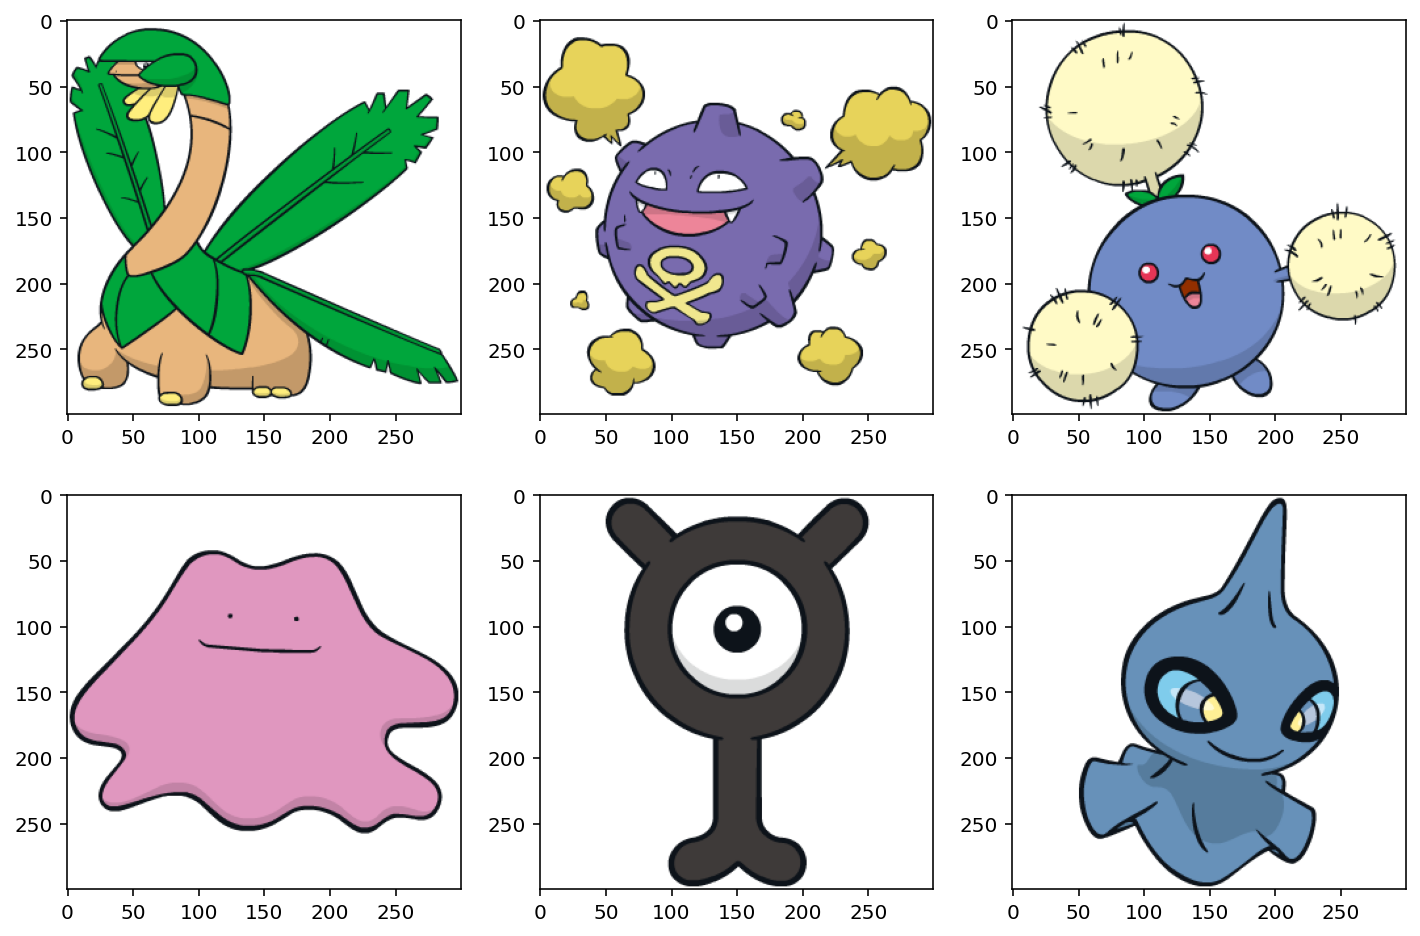

In [15]:
# Visualize source images

import random

# test_img = next(iter(train_dataset))[0][0]
# print(test_img.size())
# plt.imshow(test_img.permute(0,1))

from PIL import Image
nrows = 2
ncols = 3
file_paths = random.sample(train_image_paths, nrows * ncols)
figure, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (12, 8))
k = 0
for i in range(nrows):
  for j in range(ncols):
    axes[i][j].imshow(Image.open(file_paths[k])) #.show()
    k+=1
  # im.show()
  # display(im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

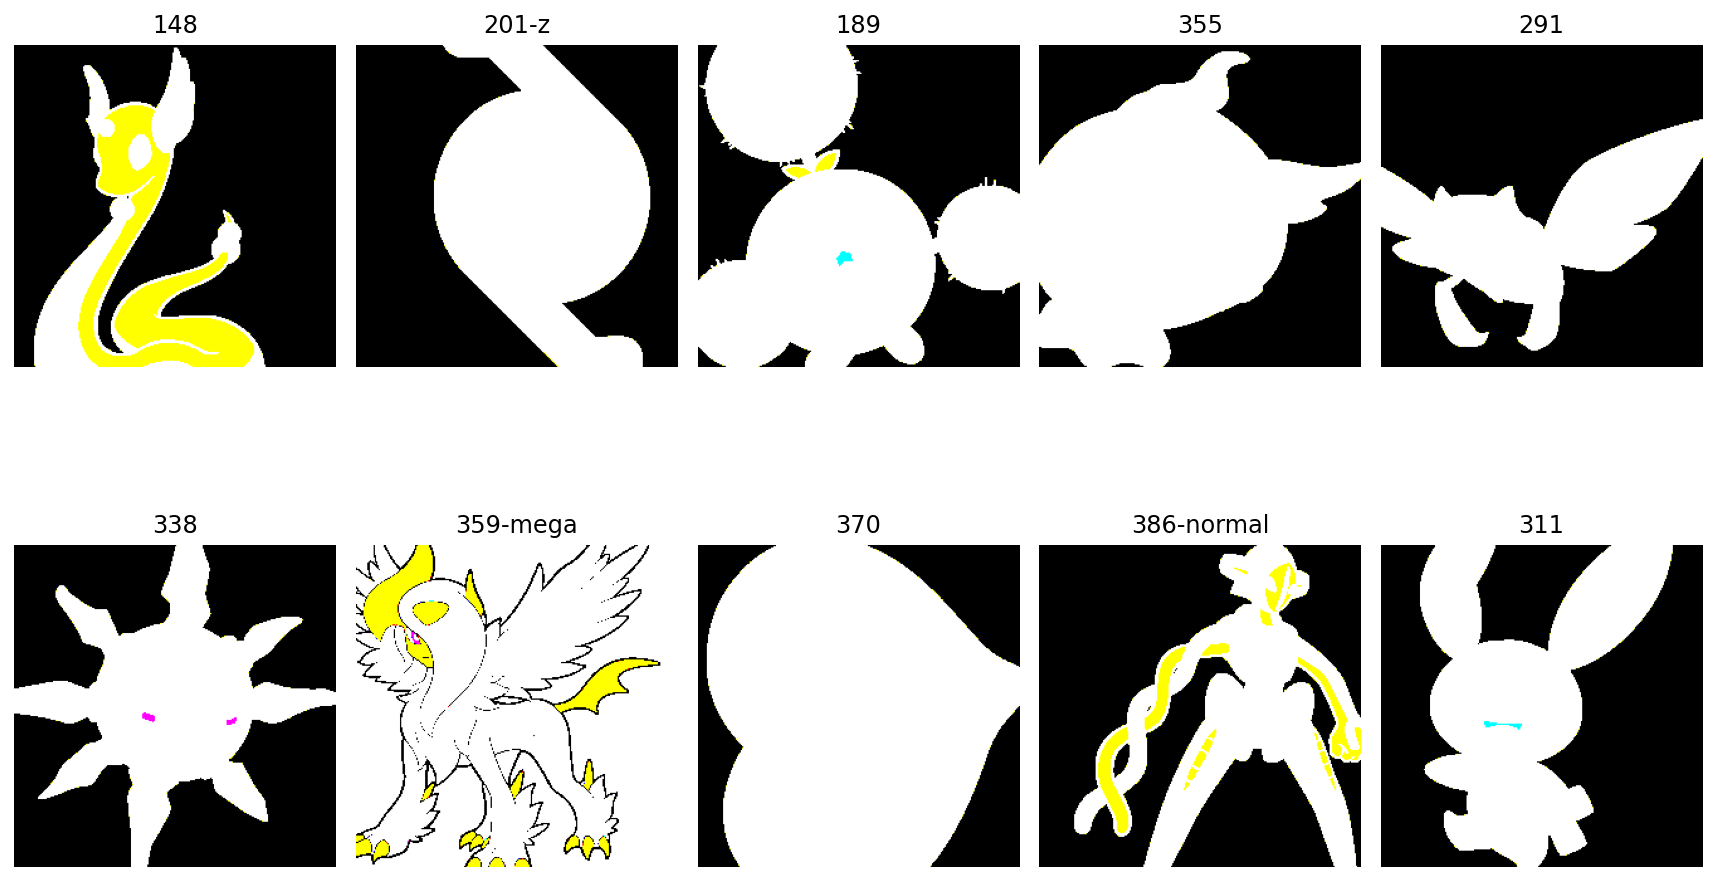

In [17]:
# Visualize images

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

In [18]:
# Data Loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [19]:
# GPU

use_cuda = torch.cuda.is_available()

torch.manual_seed(430)

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
print(use_cuda)

False


In [20]:
# Model Definition

import torch.nn as nn
import torch.nn.functional as F

class MyCNN(nn.Module):

  def __init__(self):

    super(MyCNN, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 16, 6, stride = 2, padding = 2)         #[(n+2p-f)/s + 1] = [(256+2*2-6)/2 + 1] = 128
    self.conv2 = nn.Conv2d(16, 32, 3, stride = 2, padding = 2)        #[(63+2*2-3)/2 + 1] = 33
    self.dropout1 = nn.Dropout2d(0.25)
    #self.dropout2 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(8192, 820)            #(16*16*32)*1 = 8192
    #self.fc2 = nn.Linear(1640, 820)
  
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 4, stride = 2)      #[(n-f)/s + 1] = [(128-4)/2 + 1] = 63

    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2, stride = 2)      #[(33-2)/2 + 1] = 16

    x = self.dropout1(x)  
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    #x = F.relu(x)
    #x = self.dropout2(x)
    #x = self.fc2(x)

    output = F.log_softmax(x, dim = 1)

    return output

In [21]:
# # Test cell

# x = torch.randn(size=(8, 3, 256, 256))

# # Construct the class
# map_cnn = MyCNN()

# # Predict with the network
# y = map_cnn(x)

# print(f'Output size {y.shape}')

In [22]:
# Create a new neural network model on device
model = MyCNN().to(device)
# Show layer information
print(model)

MyCNN(
  (conv1): Conv2d(3, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=8192, out_features=820, bias=True)
)


In [24]:
# Training

import torch.optim as optim

def train(model, device, train_loader, optimizer, epoch):
  # Set model to training mode
  model.train()
  global train_loss_list

  # Perform batch training
  for batch_idx, (data, target) in enumerate(train_loader):
    # Load data on device
    data = data.to(device)
    target = torch.tensor(target).to(device)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Compute prediction
    output = model(data)

    # Calculate the loss
    loss = F.nll_loss(output, target)

    # Perform backward propagation
    loss.backward()

    # Update weight parameters
    optimizer.step()

    # Show progress
    if batch_idx % 100 == 0:
      print(f'Train Epoch: {epoch}',
            f' [{batch_idx * len(data)}/{len(train_loader.dataset)}',
            f'({100. * batch_idx / len(train_loader):.0f}%)]',
            f'\tLoss: {loss.item():.6f}')
  train_loss_list.append(loss.item())

In [25]:
# Validation

def validate(model, device, valid_loader):
  # Set model to evaluation mode
  model.eval()

  # Initialize variables
  global valid_loss_list
  global valid_accuracy_list
  valid_loss = 0
  correct = 0

  # Perform computation with gradient disabled
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(valid_loader):
      # Load data on device
      data = data.to(device)
      target = torch.tensor(target).to(device)

      # Feed the network test data
      output = model(data)

      # Sum up batch loss
      valid_loss += F.nll_loss(output, target, reduction='sum').item()

      # Get the index of the max log-probability
      pred = output.argmax(dim = 1, keepdim = True)

      # Count number of correct classifications
      correct += pred.eq(target.view_as(pred)).sum().item()
      accuracy = correct/len(valid_loader.dataset)
    
  
  # Compute test loss
  valid_loss /= len(valid_loader.dataset)
  valid_loss_list.append(valid_loss)
  valid_accuracy_list.append(accuracy)

  print(f'\nValid set: Average loss: {valid_loss:.4f}',
        f'Accuracy: {accuracy:.4f}',
        f'({100. * correct / len(valid_loader.dataset):.0f}%)\n')

In [26]:
# Testing

def test(model, device, test_loader):
  # Set model to evaluation mode
  model.eval()

  # Initialize variables
  test_loss = 0
  correct = 0
  y_true = []
  y_pred = []

  # Perform computation with gradient disabled
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
      # Load data on device
      data = data.to(device)
      target = torch.tensor(target).to(device)

      # Feed the network test data
      output = model(data)

      # Sum up batch loss
      test_loss += F.nll_loss(output, target, reduction='sum').item()

      # Get the index of the max log-probability
      pred = output.argmax(dim = 1, keepdim = True)

      # Count number of correct classifications
      correct += pred.eq(target.view_as(pred)).sum().item()
      y_true.append(list(target.cpu().numpy().ravel()))
      y_pred.append(list(pred.cpu().numpy().ravel()))
  
  # Compute test loss
  test_loss /= len(test_loader.dataset)

  print(f'\nTest set: Average loss: {test_loss:.4f}',
        f'Accuracy: {correct}/{len(test_loader.dataset)}',
        f'({100. * correct / len(test_loader.dataset):.0f}%)\n')
  # return np.array(y_true).ravel(), np.array(y_pred).ravel()

In [27]:
from torch.optim.lr_scheduler import StepLR

learning_rate = 0.8
gamma = 0.7
epochs = 10

train_loss_list = []
valid_loss_list = []
valid_accuracy_list = []

# Select optimizer
optimizer = optim.Adadelta(model.parameters(), lr = learning_rate)
#optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# Setup learning rate decay
scheduler = StepLR(optimizer, step_size = 1, gamma = gamma)

# Train model over epochs
for epoch in range(1, epochs + 1):
  # Perform training routine
  train_loss = train(model, device, train_loader, optimizer, epoch)

  # Perform validation routine
  valid_loss = validate(model, device, valid_loader)

  # Decay learning rate
  scheduler.step()

# Perform testing routine
test(model, device, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Train Epoch: 1  [0/410 (0%)] 	Loss: 6.822277


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Valid set: Average loss: 6.6523 Accuracy: 0.0000 (0%)

Train Epoch: 2  [0/410 (0%)] 	Loss: 6.653172

Valid set: Average loss: 6.2183 Accuracy: 0.1098 (11%)

Train Epoch: 3  [0/410 (0%)] 	Loss: 6.573223

Valid set: Average loss: 4.5667 Accuracy: 0.3537 (35%)

Train Epoch: 4  [0/410 (0%)] 	Loss: 5.478454

Valid set: Average loss: 1.8268 Accuracy: 0.7195 (72%)

Train Epoch: 5  [0/410 (0%)] 	Loss: 3.909684

Valid set: Average loss: 0.7236 Accuracy: 0.9268 (93%)

Train Epoch: 6  [0/410 (0%)] 	Loss: 2.803317

Valid set: Average loss: 0.3406 Accuracy: 0.9756 (98%)

Train Epoch: 7  [0/410 (0%)] 	Loss: 1.037521

Valid set: Average loss: 0.2046 Accuracy: 0.9878 (99%)

Train Epoch: 8  [0/410 (0%)] 	Loss: 1.890468

Valid set: Average loss: 0.1476 Accuracy: 0.9878 (99%)

Train Epoch: 9  [0/410 (0%)] 	Loss: 0.483047

Valid set: Average loss: 0.1173 Accuracy: 0.9878 (99%)

Train Epoch: 10  [0/410 (0%)] 	Loss: 0.413203

Valid set: Average loss: 0.0984 Accuracy: 0.9878 (99%)


Test set: Average loss: 

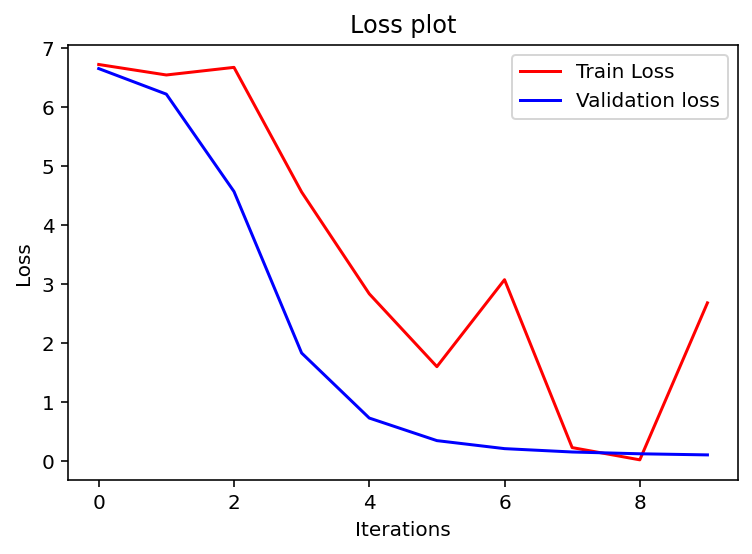

In [28]:
plt.plot(np.arange(0,len(train_loss_list)), train_loss_list, 'r-', label = "Train Loss")
plt.plot(np.arange(0,len(valid_loss_list)), valid_loss_list, 'b-', label = "Validation loss")
plt.title("Loss plot")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

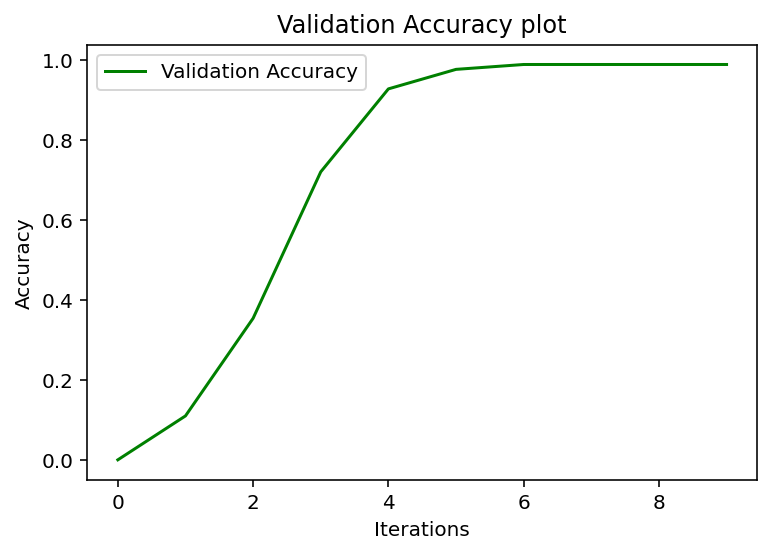

In [29]:
plt.plot(np.arange(0, len(valid_accuracy_list)), valid_accuracy_list, 'g-', label = "Validation Accuracy")
plt.title("Validation Accuracy plot")
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# Multiclass confusion matrix

# from sklearn.metrics import multilabel_confusion_matrix
# import seaborn as sns

# y_true, y_pred = test(model, device, test_loader)
# correct_classifications = 0
# wrong_classifications = 0

# for i in range(len(y_pred)):
#   correct_classifications += y_pred[i] == y_true[i]
#   wrong_classifications += y_pred[i] != y_true[i]
# print(correct_classifications)
# print(wrong_classifications)


# cf_matrix = multilabel_confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes], columns = [i for i in classes])
# plt.figure(figsize = (12,7))
# sns.heatmap(df_cm, annot=True)
# plt.savefig('output.png')